In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import mahalanobis


1. IMPORT DATASET FROM CSV

In [21]:
# file path
csv_path = "../dataset/TAIPEI_diabetes.csv" 

# create dataframe to start exploring
diabete_df = pd.read_csv(csv_path)

# check if the dataset is correctly created
diabete_df

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0
...,...,...,...,...,...,...,...,...,...,...
14995,1490300,10,65,60,46,177,33.512468,0.148327,41,1
14996,1744410,2,73,66,27,168,30.132636,0.862252,38,1
14997,1742742,0,93,89,43,57,18.690683,0.427049,24,0
14998,1099353,0,132,98,18,161,19.791645,0.302257,23,0


---
* The dataset contain 15000 rows & 10 columns
---

2. CHECK MISSING VALUE

In [3]:
# generates statistics summary
diabete_df.describe()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.502922e+06,3.224533,107.856867,71.220667,28.814000,137.852133,31.509646,0.398968,30.137733,0.333333
std,2.892534e+05,3.391020,31.981975,16.758716,14.555716,133.068252,9.759000,0.377944,12.089703,0.471420
min,1.000038e+06,0.000000,44.000000,24.000000,7.000000,14.000000,18.200512,0.078044,21.000000,0.000000
25%,1.252866e+06,0.000000,84.000000,58.000000,15.000000,39.000000,21.259887,0.137743,22.000000,0.000000
50%,1.505508e+06,2.000000,104.000000,72.000000,31.000000,83.000000,31.767940,0.200297,24.000000,0.000000
75%,1.755205e+06,6.000000,129.000000,85.000000,41.000000,195.000000,39.259692,0.616285,35.000000,1.000000
max,1.999997e+06,14.000000,192.000000,117.000000,93.000000,799.000000,56.034628,2.301594,77.000000,1.000000


---
* Count: We have 15000 Patient and all the information for those patients. So we can conclude that we have no missing value
* Mean: <br>
    in the last column (Diabetic)  we can deduce that we have 1/3 (33%) of patient which are diabetic. this population in this dataset, leaving with diabete seems above the world satistic (about 269 million on 4 billion ~ 6.57% ) <br> 
    (PlasmaGlucose) Les valeurs de glycémie de base (cad à Jeun) ne sont pas communiquées dans ce dataset. Par contre nous avons les valeurs après ingestion de la solution de glucose qui nous donne concentration de glucose dans le plasma <br> 
        Valeurs normales du glucose plasmatique apres 2 heures <br>
        1. < 140 mg/dL (7.8 mmol/L) → Normal <br>
        2. 140 - 199 mg/dL (7.8 - 11.0 mmol/L) → Intolérance au glucose (prédiabète) <br>
        3. ≥ 200 mg/dL (11.1 mmol/L) → Diabète <br>
<br>
        Ce test est souvent utilisé pour diagnostiquer : <br>
            ✅ Le diabète de type 2  <br>
            ✅ Le diabète gestationnel (chez les femmes enceintes) <br>



    Age : la moyenne d'age est 30 ans par contre la médiane-Quartile (cad 50%) est de 24. Ce qui signifierai que dans le set de donnée il y a peu de personnes interrogées qui ont un âge senior (soit environ 25% du dataset)



---

In [4]:
# vérifier que les personnes qui ont un seuil de PlasmaGlucose > 140 sont toutes diabetiques vous vérifier si c'est sur cette seule donnée que le diagnostique a été établi. ==> Ce n'est pas le cas après vérification

resultat_Diabete_Plasma = diabete_df[diabete_df['PlasmaGlucose'] > 140.0]          # resultat = diabete_df[diabete_df['PlasmaGlucose'] > 140.0]['Diabetic']
resultat_Diabete_Plasma

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
14,1683688,0,148,58,11,179,39.192076,0.160829,45,0
17,1485251,1,156,53,15,226,29.786192,0.203824,41,1
27,1398321,3,163,87,42,428,18.571188,0.777016,25,0
31,1117458,8,152,83,42,46,18.909545,0.602582,34,0
...,...,...,...,...,...,...,...,...,...,...
14957,1582615,0,156,57,35,38,21.473855,0.127779,25,0
14961,1808006,0,153,49,17,23,37.888759,0.145602,21,0
14963,1916034,6,147,89,43,17,38.549360,0.284416,23,0
14974,1752911,9,169,93,40,58,21.856319,0.792317,55,1


In [5]:
# vérifier que les personnes qui ont un seuil de PlasmaGlucose < 140 sont toutes non diabetiques vous vérifier si c'est sur cette seule donnée que le diagnostique a été établi. ==> 

resultat_nonDiabete_Plasma = diabete_df[diabete_df['PlasmaGlucose'] < 140.0]          # resultat = diabete_df[diabete_df['PlasmaGlucose'] > 140.0]['Diabetic']
resultat_nonDiabete_Plasma

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0
5,1619297,0,82,92,9,253,19.724160,0.103424,26,0
...,...,...,...,...,...,...,...,...,...,...
14995,1490300,10,65,60,46,177,33.512468,0.148327,41,1
14996,1744410,2,73,66,27,168,30.132636,0.862252,38,1
14997,1742742,0,93,89,43,57,18.690683,0.427049,24,0
14998,1099353,0,132,98,18,161,19.791645,0.302257,23,0


In [6]:
# Vérifier les dépendances des mesures médicales dans l'apparition du diabete  ==> Il y a un lien plus fort entre le vieillissement (Age) et l'apparition de Diabete et aussi entre le nombre de Grossesse et l'apparition du Diabete
# les mesures sont très peu correlées entre elles ==> donc on peut déduire que l'ensemble des colonne speuvent être utiles dans notre ML
# correlation entre l'age et la grossesse ==> laquelle des 2 est predominante dans l'apparition du diabete?

correlation = diabete_df.corr()
correlation

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
PatientID,1.000000,0.006774,-0.001858,0.008746,-0.002406,-0.020698,-0.003156,-0.015413,-0.007096,-0.012494
Pregnancies,0.006774,1.000000,0.054502,0.043528,0.063605,0.104487,0.086386,0.054240,0.136972,0.407315
PlasmaGlucose,-0.001858,0.054502,1.000000,0.007212,0.027100,0.033545,0.020653,0.009057,0.038864,0.128004
DiastolicBloodPressure,0.008746,0.043528,0.007212,1.000000,0.011106,0.022649,0.015873,0.014099,0.041333,0.091307
TricepsThickness,-0.002406,0.063605,0.027100,0.011106,1.000000,0.029688,0.024745,-0.000951,0.061383,0.152505
SerumInsulin,-0.020698,0.104487,0.033545,0.022649,0.029688,1.000000,0.051223,0.046324,0.088007,0.247375
BMI,-0.003156,0.086386,0.020653,0.015873,0.024745,0.051223,1.000000,0.028868,0.062910,0.210508
DiabetesPedigree,-0.015413,0.054240,0.009057,0.014099,-0.000951,0.046324,0.028868,1.000000,0.055633,0.170302
Age,-0.007096,0.136972,0.038864,0.041333,0.061383,0.088007,0.062910,0.055633,1.000000,0.342605
Diabetic,-0.012494,0.407315,0.128004,0.091307,0.152505,0.247375,0.210508,0.170302,0.342605,1.000000


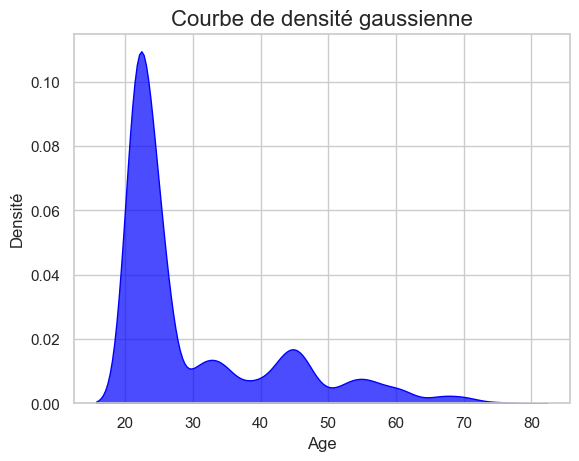

In [13]:
# objectif: focus sur l'age pour voir comment le set est construit. on peut constater que la grande majorité des données prélevées ce sont faites sur la tranche d'age de 20 à 3O ans


sns.set(style="whitegrid")
sns.kdeplot(diabete_df['Age'], fill=True, color="blue", alpha=0.7)

# Ajouter un titre et des labels
plt.title("Courbe de densité gaussienne", fontsize=16)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Densité", fontsize=12)

# Afficher le graphique
plt.show()

In [9]:
age_inf_30 = diabete_df[diabete_df['Age'] <= 30.0]          # resultat = diabete_df[diabete_df['PlasmaGlucose'] > 140.0]['Diabetic']
age_inf_30.Age.describe()

count    10280.000000
mean        23.026751
std          1.960443
min         21.000000
25%         22.000000
50%         23.000000
75%         24.000000
max         30.000000
Name: Age, dtype: float64

In [10]:
age_30_40 = diabete_df[diabete_df['Age'] <= 40.0]
age_30_40 = age_30_40[age_30_40['Age'] > 30]        
age_30_40.Age.describe()

count    1554.000000
mean       34.622909
std         2.741612
min        31.000000
25%        32.000000
50%        34.000000
75%        37.000000
max        40.000000
Name: Age, dtype: float64

In [11]:
age_sup_35 = diabete_df[diabete_df['Age'] > 35.0]          
age_sup_35.Age.describe()

count    3633.000000
mean       49.380127
std         8.720514
min        36.000000
25%        43.000000
50%        46.000000
75%        55.000000
max        77.000000
Name: Age, dtype: float64

In [ ]:
# 70% des plus de 35 ans ont le diabete .Donc l'age est assez déterminant dans cette analyse. et dans les moins de 22ans le taux est de 34%
# balancer cette analyse avec le nombre de grossesse


tranche_dage = [(0,22),(22,24),(24,35),(35,77)]
for i in tranche_dage:
    x,y = i
    age_x_y = diabete_df[diabete_df['Age'] > x]
    age_x_y = age_x_y[age_x_y['Age'] <=y]
    print("count ",age_x_y.Diabetic.count())

    print("diabete",age_x_y.Diabetic.mean())


count  5042
diabete 0.34192780642602144
count  2956
diabete 0.11772665764546685
count  3369
diabete 0.10834075393291778
count  3633
diabete 0.705477566749243


In [ ]:

# c'est sur ces 2 tranches d'age discuté plus haut que le nombre de grossesse moyenne est le plus élevé 

tranche_dage = [(0,22),(22,24),(24,35),(35,77)]
for i in tranche_dage:
    x,y = i
    age_x_y = diabete_df[diabete_df['Age'] > x]
    age_x_y = age_x_y[age_x_y['Age'] <=y]
    print("count ",age_x_y.Diabetic.count())
    print("pregnancies ",age_x_y.Pregnancies.mean())

    print("diabete",age_x_y.Diabetic.mean())

count  5042
pregnancies  3.2538675128917096
diabete 0.34192780642602144
count  2956
pregnancies  2.6275372124492558
diabete 0.11772665764546685
count  3369
pregnancies  2.5399228257643216
diabete 0.10834075393291778
count  3633
pregnancies  4.304431599229287
diabete 0.705477566749243


In [22]:
for i in range(diabete_df.Pregnancies.max()+1):
    Total_women_per_Pregnancies = diabete_df[diabete_df['Pregnancies'] == i]
    print(f"pour {i} grossesses : ",Total_women_per_Pregnancies.Diabetic.count(), "diabete ", Total_women_per_Pregnancies.Diabetic.mean())

pour 0 grossesses :  4377 diabete  0.012108750285583733
pour 1 grossesses :  2864 diabete  0.08030726256983241
pour 2 grossesses :  939 diabete  0.8242811501597445
pour 3 grossesses :  1219 diabete  0.6808859721082855
pour 4 grossesses :  675 diabete  0.8740740740740741
pour 5 grossesses :  687 diabete  0.87627365356623
pour 6 grossesses :  1070 diabete  0.37009345794392523
pour 7 grossesses :  895 diabete  0.22346368715083798
pour 8 grossesses :  645 diabete  0.6573643410852713
pour 9 grossesses :  881 diabete  0.5266742338251986
pour 10 grossesses :  450 diabete  0.40444444444444444
pour 11 grossesses :  143 diabete  0.6993006993006993
pour 12 grossesses :  57 diabete  1.0
pour 13 grossesses :  69 diabete  1.0
pour 14 grossesses :  29 diabete  1.0


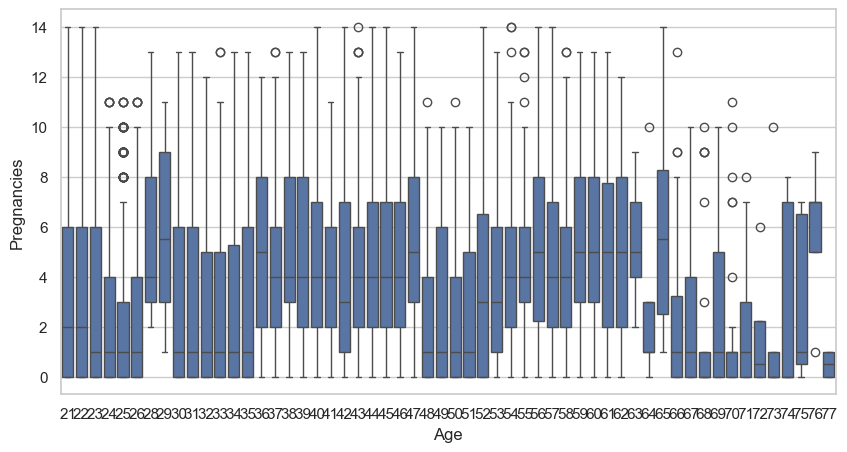

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
count,2.900000e+01,29.0,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.0
mean,1.508652e+06,14.0,122.310345,70.965517,34.000000,215.965517,35.696135,0.509534,34.275862,1.0
std,2.848301e+05,0.0,24.540205,14.383728,20.046375,178.932047,8.733631,0.441322,14.932937,0.0
min,1.017278e+06,14.0,70.000000,24.000000,9.000000,20.000000,18.453881,0.098536,21.000000,1.0
25%,1.333363e+06,14.0,107.000000,64.000000,21.000000,78.000000,30.665377,0.149536,22.000000,1.0
50%,1.445933e+06,14.0,118.000000,71.000000,30.000000,182.000000,35.803242,0.264857,23.000000,1.0
75%,1.723630e+06,14.0,137.000000,84.000000,43.000000,303.000000,40.253790,0.834632,47.000000,1.0
max,1.999765e+06,14.0,173.000000,92.000000,92.000000,682.000000,51.525250,1.528477,65.000000,1.0


In [26]:

plt.figure(figsize=(10,5))
sns.boxplot(x=diabete_df.Age,y=diabete_df.Pregnancies)
plt.show()
Total_women_per_Pregnancies = diabete_df[diabete_df['Pregnancies'] == 14]
Total_women_per_Pregnancies.describe()


In [23]:
# Suppression de la colonne 'PatientID'

diabete_df_dropID = diabete_df.drop(columns=['PatientID'])
#print(diabete_df)

# Vérifier les dimensions des tableaux
print(diabete_df_dropID.shape)

# Calcul de la moyenne et de la matrice de covariance
mean_vector = diabete_df_dropID.mean()
cov_matrix = np.cov(diabete_df_dropID.T)
inv_cov_matrix = np.linalg.inv(cov_matrix)

print(mean_vector.shape)  # Doit être de la forme (9,)
print(inv_cov_matrix.shape)

# Calcul de la distance de Mahalanobis
my_distance = diabete_df_dropID.apply(lambda row: mahalanobis(row, mean_vector, inv_cov_matrix), axis=1)

# Définition du seuil d'outlier (généralement, un seuil > 3 ou 4 est utilisé)
threshold = 4  # ou 4 selon la rigueur souhaitée
outliers = diabete_df_dropID[my_distance > threshold]

outliers


(15000, 9)
(9,)
(9, 9)


,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
30,11,75,89,8,541,29.422754,0.083732,47,1
33,3,123,61,29,46,28.091062,1.893404,25,0
47,9,104,51,7,24,27.369832,1.350472,43,1
48,6,73,61,35,24,18.743674,1.074148,75,0
67,4,104,68,91,250,27.871104,1.212582,50,1
...,...,...,...,...,...,...,...,...,...
14935,1,108,78,23,529,51.334246,0.100003,44,1
14938,1,114,81,10,127,46.677473,0.140449,70,0
14943,1,119,42,7,618,41.501977,0.156410,21,0
14952,13,96,66,48,48,36.174369,1.294610,39,1


In [24]:
outliers.describe()

,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
count,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000
mean,4.450175,111.520979,71.709790,30.977273,302.369755,32.421127,0.753462,41.586538,0.455420
std,4.074670,37.319827,19.048762,18.472921,250.289433,10.336865,0.681631,19.274311,0.498226
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.203229,0.078093,21.000000,0.000000
25%,1.000000,83.000000,57.000000,13.750000,60.000000,21.595688,0.154101,23.000000,0.000000
50%,3.000000,106.000000,74.000000,31.000000,218.000000,32.039710,0.505248,39.000000,0.000000
75%,8.000000,141.000000,86.000000,44.000000,557.250000,40.156039,1.393429,61.000000,1.000000
max,14.000000,191.000000,116.000000,93.000000,799.000000,55.975311,2.301594,77.000000,1.000000


In [25]:
outliers[outliers["Age"] == 21]

,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
87,2,104,62,54,593,40.496200,0.548991,21,1
113,3,120,61,46,597,28.550511,0.273248,21,1
156,8,169,81,54,60,30.196837,1.510411,21,1
384,9,139,97,46,593,35.818773,0.754862,21,1
488,4,114,79,45,601,51.210784,0.177544,21,1
...,...,...,...,...,...,...,...,...,...
14667,2,108,69,13,567,35.173838,0.133393,21,1
14741,5,142,78,27,514,55.646594,0.204484,21,1
14874,4,180,49,7,547,31.222934,0.151022,21,1
14928,12,176,95,48,396,30.363768,0.162074,21,1
